 CPES SMR Attack graph quantification

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the attack graph
attack_graph = {
    "L1": ["L1.1", "L1.2"],
    "L1.1": ["L1.1.1", "L1.1.2"],
    "L1.1.1": ["L2.1.1"],
    "L1.1.2": ["L2.1.2"],
    "L1.2": ["L1.2.1", "L1.2.2"],
    "L2.1.1": ["L2.1.1.1", "L2.1.1.2"],
    "L2.1.2": ["L2.1.2.1", "L2.1.2.2"]
}


# Create a directed graph

In [10]:

G = nx.DiGraph()
for node, children in attack_graph.items():
    for child in children:
        G.add_edge(node, child)



Most Critical Nodes (Greatest Impact on L1):
L1.1: 0.099
L1.2: 0.099
L1.1.1: 0.000
L1.1.2: 0.000
L2.1.1: 0.000


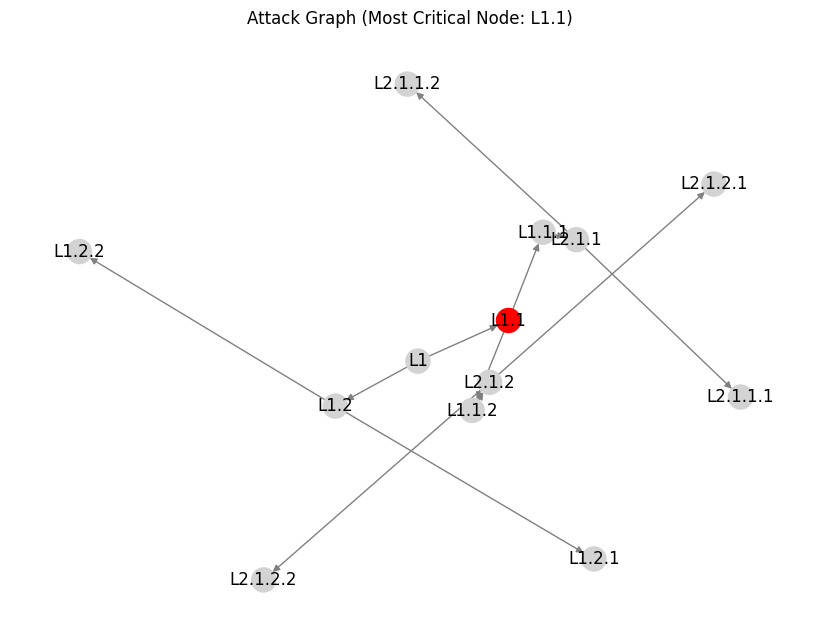

In [16]:
# Compute logical weights (AND logic using min())
def compute_logical_weight(G):
    logical_weights = {node: 0.1 for node in G.nodes()}  # Set all leaf nodes to 0.1

    def helper(node):
        children = list(G.successors(node))
        if not children:
            return logical_weights[node]  # Leaf node

        # AND condition: Take min of children
        logical_weights[node] = min(helper(child) for child in children)
        return logical_weights[node]

    for node in reversed(list(nx.topological_sort(G))):
        logical_weights[node] = helper(node)

    # Ensure L1.1 and L1.2 exist before applying AND logic
    l1_1_weight = logical_weights.get("L1.1", 0.001)  # Default to 0 if missing
    l1_2_weight = logical_weights.get("L1.2", 0.001)  # Default to 0 if missing
    logical_weights["L1"] = min(l1_1_weight, l1_2_weight)  # Apply AND to root
    return logical_weights

# Compute initial weights
initial_weights = compute_logical_weight(G)
baseline_L1 = initial_weights["L1"]

# Wrapper Method: Remove each node and measure severity drop
critical_nodes = {}

for node in list(G.nodes()):
    if node == "L1":  # Don't remove root node
        continue

    # Create a modified attack graph excluding the removed node
    modified_attack_graph = {n: [child for child in children if child != node] 
                             for n, children in attack_graph.items() if n != node}

    G_temp = nx.DiGraph()
    for n, children in modified_attack_graph.items():
        for child in children:
            G_temp.add_edge(n, child)

    new_weights = compute_logical_weight(G_temp)

    # Compute the change in L1 severity
    impact = baseline_L1 - new_weights.get("L1", 0)  # If L1 disappears, assume 0
    critical_nodes[node] = impact

# Rank nodes by impact on L1
sorted_critical_nodes = sorted(critical_nodes.items(), key=lambda x: -x[1])

# Print most critical nodes
print("Most Critical Nodes (Greatest Impact on L1):")
for node, impact in sorted_critical_nodes[:5]:  # Show top 5
    print(f"{node}: {impact:.3f}")

# Plot original graph with critical node highlighted
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
node_colors = ["red" if node == sorted_critical_nodes[0][0] else "lightgray" for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Reds, edge_color="gray")
plt.title(f"Attack Graph (Most Critical Node: {sorted_critical_nodes[0][0]})")
plt.show()